In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

math = pd.read_csv('stud_math.xls')

# Первичный Aнализ


In [2]:
# переименую некоторые колонки, уберу сложные название и все будут с маленькой буквы

math.columns = ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
                'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health', 'absences', 'score']

In [3]:
# Напишу пару функций чтоб было удобней работать с многочислеными данными из таблицы Math

# Функция ниже выдает важную статистику по столбцу и график хистограммы
# для числовых переменных

def column_stats(table, column, num_bins=5):
    display(table[column].value_counts())
    display(table[column].describe())
    table[column].hist(bins=num_bins)


# Функция ниже зачищает столбик от выбрасов если такии есть
# заполняя их места медианой.

def del_outliers(table, column):
    perc25 = table[column].quantile(0.25)
    perc75 = table[column].quantile(0.75)
    perc50 = table[column].quantile(0.5)

    def filter_outliers(value):
        low_bound = perc25 - 1.5 * (perc75 - perc25)
        top_bound = perc75 + 1.5 * (perc75 - perc25)

        if (value >= low_bound) & (value <= top_bound):
            return value
        else:
            return perc50

    new_column = table[column].apply(filter_outliers)

    return new_column



# функция ниже чтоб посмотреть статистику по номинальной колонки

def column_stats_nom(table, column):
    display(table[column].value_counts())
    display(table[column].describe())
    display(table.loc[:, [column]].info())


# Функция ниже заполняет пустые значения в колонках содержащих номинальные переменные.
# Параметр option имеет два заудманых значения 1 если цель заполнить пустые значения
# самым часто встречающимся значением или 2 если цель заполнить пропуски используя None
# остальные значения параметр option будет передовать напрямую в пропуск.

def replade_nans(table, column, option):
    if option == 1:
        new_val = table[column].value_counts().index[0]
    elif option == 2:
        new_val = None
    else:
        new_val = option

    table[column] = table[column].apply(lambda x: new_val if pd.isnull(x) else new_val if x == 'nan'
                                        else x if '(' not in x else x[:x.find('(')].strip())

    display(table.loc[:, [column]].info())

# Числовые Переменные

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

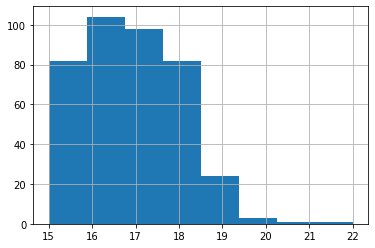

In [4]:
# 3) age

column_stats(math, 'age', 8)

In [5]:
# Согласно статистики и хистограмме очень мало учеников в возрасте 19 и старше. В этом возрастном промежутке скорее всего будут
# выбросы после применения функции del_outliers. Впринцепе в школах и не учатся ученики старше 18 лет

math.age = del_outliers(math, 'age')

16.0    104
17.0     99
15.0     82
18.0     82
19.0     24
20.0      3
21.0      1
Name: age, dtype: int64

count    395.000000
mean      16.683544
std        1.247783
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       21.000000
Name: age, dtype: float64

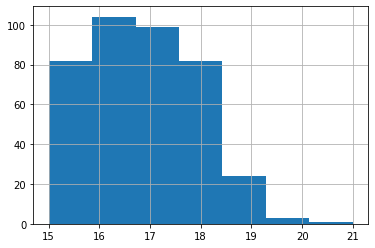

In [6]:
column_stats(math, 'age', 7)

In [7]:
# Что и следовало ожидать, ученик в возрасте 22 лет это выброс

# medu

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: medu, dtype: int64

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

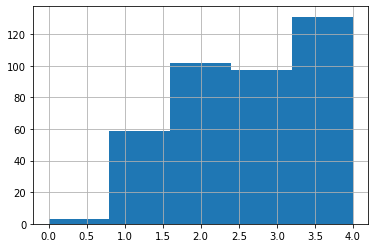

In [8]:
# 7) medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

column_stats(math, 'medu')

In [9]:
# Количество матерей только возростает с оброзванем в этой таблице, без образование совсем матерей мало.
# Но это не выбросы, а крайнии значения такии

# fedu


2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: fedu, dtype: int64

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

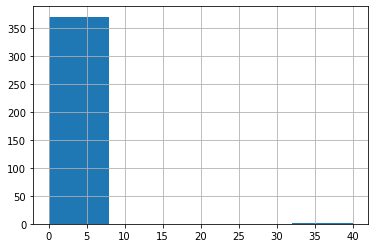

In [10]:
# 8) fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

column_stats(math, 'fedu')

2.0    133
3.0     96
4.0     88
1.0     78
Name: fedu, dtype: int64

count    395.000000
mean       2.491139
std        1.045560
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

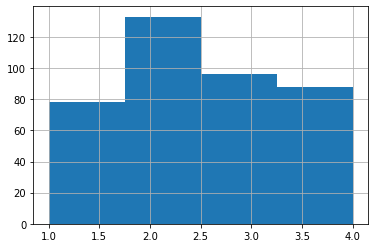

In [11]:
# Ошибка в данные закралась, потому что величины 40 даже быть не может, максимальное значение 4
# надо его убрать и почистить колонку от выбросов
# Из статистике по колонке видно что среди отцов преоблодает среднее образование в отличии от матерей
# среди которых больше всего высшего образования

math.fedu = del_outliers(math, 'fedu')
column_stats(math, 'fedu', 4)

In [12]:
# Отцы без образования это выбросы

# traveltime


1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

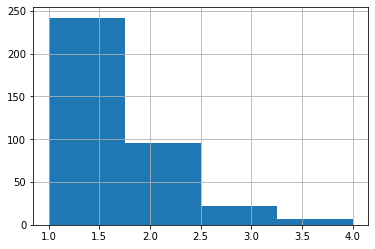

In [13]:
# 13) traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

column_stats(math, 'traveltime', 4)

1.0    277
2.0     96
3.0     22
Name: traveltime, dtype: int64

count    395.000000
mean       1.354430
std        0.584008
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: traveltime, dtype: float64

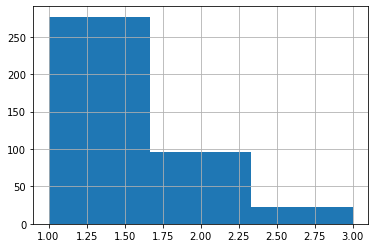

In [14]:
# Подовляющее колличество учеников траятят на дорогу до 15 минут
# Очень мало учеников в таблице которые тратят больше 6 минут и эта область выбросов

math.traveltime = del_outliers(math, 'traveltime')
column_stats(math, 'traveltime', 3)

# studytime


2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

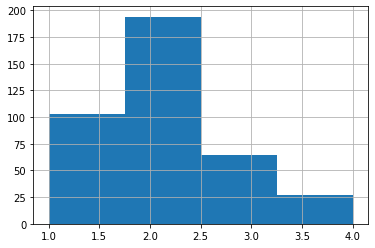

In [15]:
# 14) studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

column_stats(math, 'studytime', 4)

2.0    228
1.0    103
3.0     64
Name: studytime, dtype: int64

count    395.000000
mean       1.901266
std        0.643494
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: studytime, dtype: float64

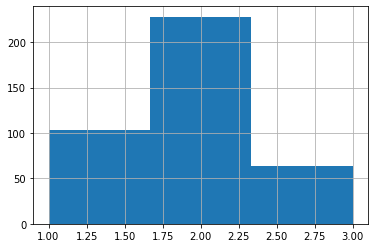

In [16]:
# Большенство учеников тратит до 5 часов в неделю на учебу помимо школы.
# Учеников которые тратят больше 10 часов в неделю очень мало и это зона выбросов

math.studytime = del_outliers(math, 'studytime')
column_stats(math, 'studytime', 3)

# failures


0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

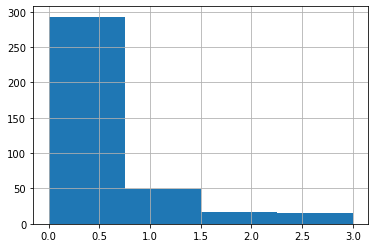

In [17]:
# 15) failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

column_stats(math, 'failures', 4)

0.0    395
Name: failures, dtype: int64

count    395.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: failures, dtype: float64

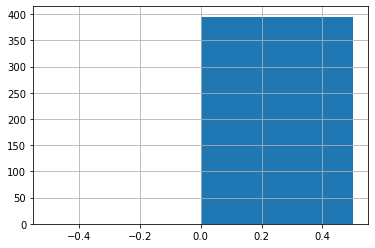

In [18]:
# У подовляющего большенства учеников не было неудач, а у тех кого были их мало и они в зоне выбросов

math.failures = del_outliers(math, 'failures')
column_stats(math, 'failures', 2)

# famrel


 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

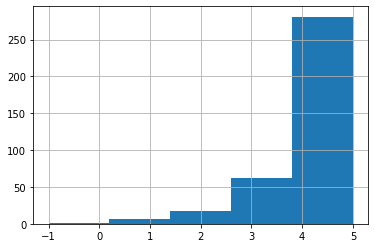

In [19]:
# 24) famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

column_stats(math, 'famrel')

4.0    234
5.0     99
3.0     62
Name: famrel, dtype: int64

count    395.000000
mean       4.093671
std        0.632323
min        3.000000
25%        4.000000
50%        4.000000
75%        4.500000
max        5.000000
Name: famrel, dtype: float64

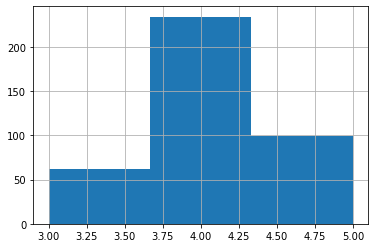

In [20]:
# Ошибка в данных значение -1 не должно вообще быть
# У значительного большинства учеников хорошии отношения в семье
# Плохих отношений ниже 3 мало и они в зоне выбросов

math.famrel = del_outliers(math, 'famrel')
column_stats(math, 'famrel', 3)

# freetime


3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
Name: freetime, dtype: int64

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

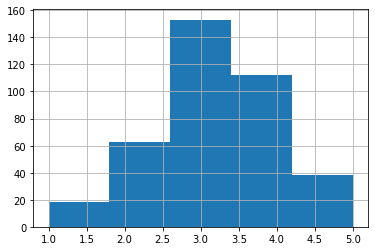

In [21]:
# 25) freetime — свободное время после школы (от 1 - очень мало до 5 - очень много)

column_stats(math, 'freetime')

3.0    182
4.0    112
2.0     63
5.0     38
Name: freetime, dtype: int64

count    395.000000
mean       3.316456
std        0.854137
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

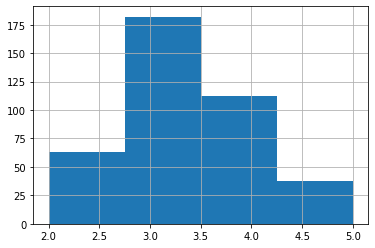

In [22]:
# У большенства учеников немного и не мало свободного времени после школы
# Учеников у которых совсем мало свободного времени не большое количество и они в зоне выбросов

math.freetime = del_outliers(math, 'freetime')
column_stats(math, 'freetime', 4)

# goout

3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

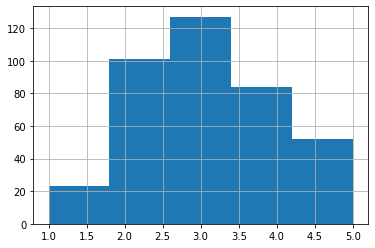

In [23]:
# 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

column_stats(math, 'goout')

In [24]:
# Большенство учеников проводит време с друзьями не очень мало и не очень много.

# health


5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
Name: health, dtype: int64

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

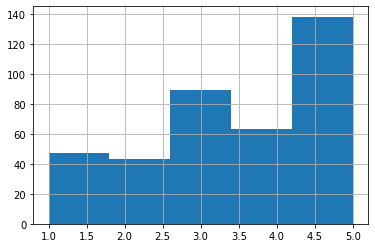

In [25]:
# 27)  health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

column_stats(math, 'health')

In [26]:
# У трети учеников очень хорошое здоровье а у остольных почти равномерно от плохого до хорошего
# Но выбросов нет

# absences


0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

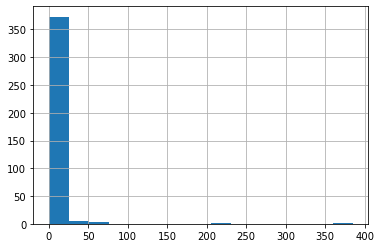

In [27]:
# 28) absences — количество пропущенных занятий

column_stats(math, 'absences', 15)

0.0     111
4.0      82
2.0      60
6.0      31
8.0      21
10.0     17
12.0     12
14.0     12
3.0       8
16.0      7
7.0       6
18.0      5
5.0       5
20.0      4
1.0       3
9.0       3
11.0      2
13.0      2
15.0      2
19.0      1
17.0      1
Name: absences, dtype: int64

count    395.000000
mean       4.559494
std        4.781880
min        0.000000
25%        0.000000
50%        4.000000
75%        6.000000
max       20.000000
Name: absences, dtype: float64

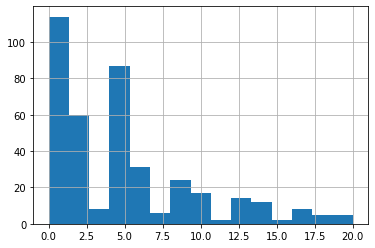

In [28]:
# У трети студендов не было пропусков
# У значительного большенства до 15 пропусков, сразу заметно что имеются выбросы

math.absences = del_outliers(math, 'absences')
column_stats(math, 'absences', 15)

-6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: studytime_granular, dtype: int64

count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_granular, dtype: float64

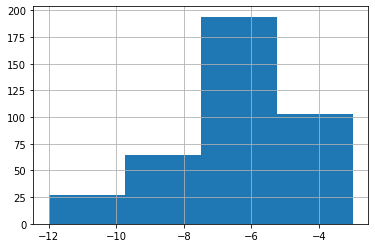

In [29]:
column_stats(math, 'studytime_granular', 4)

-6.0    228
-3.0    103
-9.0     64
Name: studytime_granular, dtype: int64

count    395.000000
mean      -5.703797
std        1.930482
min       -9.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_granular, dtype: float64

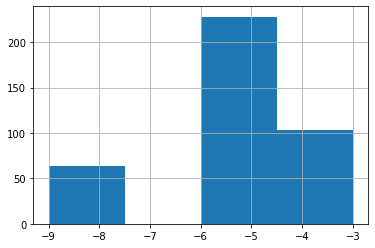

In [30]:
math.studytime_granular = del_outliers(math, 'studytime_granular')
column_stats(math, 'studytime_granular', 4)

# score



50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

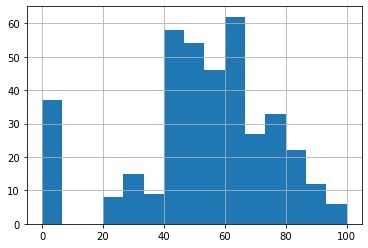

In [31]:
# 29) score — баллы по госэкзамену по математике

column_stats(math, 'score', 15)

In [32]:
# Среди оценок выбросов не наблюдается.

# Номинативные Переменные



# school

In [33]:
# 1) school аббревиатура школы, в которой учится ученик

column_stats_nom(math, 'school')

GP    349
MS     46
Name: school, dtype: int64

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [34]:
# Школ под абривиатурой GP значительно больше чем MS школ

# sex

In [35]:
# 2) sex — пол ученика ('F' - женский, 'M' - мужской)

column_stats_nom(math, 'sex')

F    208
M    187
Name: sex, dtype: int64

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [36]:
# Девочек не много больше чем мальчиков.

# address

In [37]:
# 4) address — тип адреса ученика ('U' - городской, 'R' - за городом)

column_stats_nom(math, 'address')
replade_nans(math, 'address', 1)

U    295
R     83
Name: address, dtype: int64

count     378
unique      2
top         U
freq      295
Name: address, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [38]:
# Городских учеников значительно больше в таблице чем тех кто за городом живет.

# famsize

In [39]:
# 5) famsize — размер семьи('LE3' <= 3, 'GT3' >3)

column_stats_nom(math, 'famsize')

GT3    261
LE3    107
Name: famsize, dtype: int64

count     368
unique      2
top       GT3
freq      261
Name: famsize, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [40]:
# Семей где больше 3 человек на много больше, многии люди имеют больше одного ребенка видимо.
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'famsize', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# pstatus

In [41]:
# 6) pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

column_stats_nom(math, 'pstatus')

T    314
A     36
Name: pstatus, dtype: int64

count     350
unique      2
top         T
freq      314
Name: pstatus, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pstatus  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [42]:
# Не удивительно после переменной famsize, что у подовляющего числа учеников родители живут вместе
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'pstatus', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pstatus  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# mjob

In [43]:
# 9) mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба,
#                        'at_home' - не работает, 'other' - другое)

column_stats_nom(math, 'mjob')

other       133
services     98
at_home      58
teacher      55
health       32
Name: mjob, dtype: int64

count       376
unique        5
top       other
freq        133
Name: mjob, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [44]:
# В районе трети матерей работает на какихто других работах, и четверть матерей на гос службе
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'mjob', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# fjob

In [45]:
# 10) fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба,
#                       'at_home' - не работает, 'other' - другое)

column_stats_nom(math, 'fjob')

other       197
services    102
teacher      29
at_home      16
health       15
Name: fjob, dtype: int64

count       359
unique        5
top       other
freq        197
Name: fjob, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [46]:
# Среди отцов еще больше работает на какихто других работах, и на гос службе
# и на много меньше сидят дома чем среди матерей
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'fjob', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# reason

In [47]:
# 11) reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы,
# 'course' - образовательная программа, 'other' - другое)

column_stats_nom(math, 'reason')

course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64

count        378
unique         4
top       course
freq         137
Name: reason, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [48]:
# причина выбора школ достаточно равномерно распределены, кроме другое
# скорее всего самые основные причины это три первых
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'reason', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# guardian


In [49]:
# 12) guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

column_stats_nom(math, 'reason')

course        154
home          104
reputation    103
other          34
Name: reason, dtype: int64

count        395
unique         4
top       course
freq         154
Name: reason, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [50]:
# у значительного большенства учеников опекун мать

# schoolsup

In [51]:
# 16) schoolsup — дополнительная образовательная поддержка (yes или no)

column_stats_nom(math, 'reason')

course        154
home          104
reputation    103
other          34
Name: reason, dtype: int64

count        395
unique         4
top       course
freq         154
Name: reason, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [52]:
# У подавляющего большенства учеников такой поддержки нет

# famsup


In [53]:
# 17) famsup — семейная образовательная поддержка (yes или no)

column_stats_nom(math, 'famsup')

yes    219
no     137
Name: famsup, dtype: int64

count     356
unique      2
top       yes
freq      219
Name: famsup, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [54]:
# большенство учеников получает семейную образовательную поддержку
# компенсируется наверно этим предыдущую переменную schoolsup
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'famsup', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# paid

In [55]:
# 18) paid — дополнительные платные занятия по математике (yes или no)

column_stats_nom(math, 'paid')

no     200
yes    155
Name: paid, dtype: int64

count     355
unique      2
top        no
freq      200
Name: paid, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [56]:
# немного меньше учеников получает дополнительные платные занятия по матекматике
# чем тех которые не получает, но всеравно значительное количество
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'paid', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# activities


In [57]:
# 19) activities — дополнительные внеучебные занятия (yes или no)

column_stats_nom(math, 'activities')

yes    195
no     186
Name: activities, dtype: int64

count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [58]:
# почти равное количество учеников заняты и не заняты дополнительными внеучебными занятиями
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'activities', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# nursery 


In [59]:
# 20) nursery — посещал детский сад (yes или no)

column_stats_nom(math, 'nursery')

yes    300
no      79
Name: nursery, dtype: int64

count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [60]:
# Подовляющее большенство учеников посещала детский сад.
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'nursery', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# higher


In [61]:
# 21) higher — хочет получить высшее образование (yes или no)

column_stats_nom(math, 'higher')

yes    356
no      19
Name: higher, dtype: int64

count     375
unique      2
top       yes
freq      356
Name: higher, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [62]:
# почти все ученики хотят получить высшее образование
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'higher', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# internet


In [63]:
# 22) internet — наличие интернета дома (yes или no)

column_stats_nom(math, 'internet')

yes    305
no      56
Name: internet, dtype: int64

count     361
unique      2
top       yes
freq      305
Name: internet, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [64]:
# У очень значительного большенства имеется интернет дома
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'internet', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# romantic


In [65]:
# 23) romantic — в романтических отношениях (yes или no)

column_stats_nom(math, 'romantic')

no     240
yes    124
Name: romantic, dtype: int64

count     364
unique      2
top        no
freq      240
Name: romantic, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

In [66]:
# только треть учеников в романтических отношениях
# В столбике есть пропуски, которые я заполню самым частым значением

replade_nans(math, 'romantic', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

# Корреляционный Анализ

In [67]:
math.corr()

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.167711,-0.149035,0.115995,0.062139,NaN,-0.062139,0.040882,0.025141,0.120664,-0.048418,0.119927,-0.153825
medu,-0.167711,1.000000,0.606609,-0.111395,0.088561,NaN,-0.088561,0.052626,0.015702,0.064164,-0.045051,0.062340,0.213349
fedu,-0.149035,0.606609,1.000000,-0.065506,0.072257,NaN,-0.072257,-0.004500,-0.035219,0.039362,0.001471,-0.026672,0.130696
traveltime,0.115995,-0.111395,-0.065506,1.000000,-0.116009,NaN,0.116009,-0.042021,-0.062603,-0.026985,-0.060383,-0.053012,-0.056758
studytime,0.062139,0.088561,0.072257,-0.116009,1.000000,NaN,-1.000000,0.072688,-0.086159,-0.045545,-0.044405,-0.078506,0.110634
failures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studytime_granular,-0.062139,-0.088561,-0.072257,0.116009,-1.000000,NaN,1.000000,-0.072688,0.086159,0.045545,0.044405,0.078506,-0.110634
famrel,0.040882,0.052626,-0.004500,-0.042021,0.072688,NaN,-0.072688,1.000000,0.109453,0.087378,0.025072,-0.020734,0.054263
freetime,0.025141,0.015702,-0.035219,-0.062603,-0.086159,NaN,0.086159,0.109453,1.000000,0.262956,0.055041,0.084551,0.001483
goout,0.120664,0.064164,0.039362,-0.026985,-0.045545,NaN,0.045545,0.087378,0.262956,1.000000,-0.015608,0.104608,-0.129685


In [68]:
# Надо удалить столбик studytime_granular, потому что он коррелирует полностью с столбиком studytime
# плюс к нему даже нет обьяснения в задании

del math['studytime_granular']
math.corr()

,age,medu,fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.167711,-0.149035,0.115995,0.062139,NaN,0.040882,0.025141,0.120664,-0.048418,0.119927,-0.153825
medu,-0.167711,1.000000,0.606609,-0.111395,0.088561,NaN,0.052626,0.015702,0.064164,-0.045051,0.062340,0.213349
fedu,-0.149035,0.606609,1.000000,-0.065506,0.072257,NaN,-0.004500,-0.035219,0.039362,0.001471,-0.026672,0.130696
traveltime,0.115995,-0.111395,-0.065506,1.000000,-0.116009,NaN,-0.042021,-0.062603,-0.026985,-0.060383,-0.053012,-0.056758
studytime,0.062139,0.088561,0.072257,-0.116009,1.000000,NaN,0.072688,-0.086159,-0.045545,-0.044405,-0.078506,0.110634
failures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famrel,0.040882,0.052626,-0.004500,-0.042021,0.072688,NaN,1.000000,0.109453,0.087378,0.025072,-0.020734,0.054263
freetime,0.025141,0.015702,-0.035219,-0.062603,-0.086159,NaN,0.109453,1.000000,0.262956,0.055041,0.084551,0.001483
goout,0.120664,0.064164,0.039362,-0.026985,-0.045545,NaN,0.087378,0.262956,1.000000,-0.015608,0.104608,-0.129685
health,-0.048418,-0.045051,0.001471,-0.060383,-0.044405,NaN,0.025072,0.055041,-0.015608,1.000000,-0.011815,-0.070460


In [69]:
# Из оставшихся столбиков заметно коррелируют medu (образование матери), fedu (образование отца),
# age (возраст), studytime (время на учёбу помимо школы в неделю), goout (проведение времени с друзьями)
# все остальные числовые столбики можно убрать

math = math.drop(['traveltime', 'failures', 'famrel',
                  'freetime', 'health', 'absences'], axis=1)
math.corr()

,age,medu,fedu,studytime,goout,score
age,1.000000,-0.167711,-0.149035,0.062139,0.120664,-0.153825
medu,-0.167711,1.000000,0.606609,0.088561,0.064164,0.213349
fedu,-0.149035,0.606609,1.000000,0.072257,0.039362,0.130696
studytime,0.062139,0.088561,0.072257,1.000000,-0.045545,0.110634
goout,0.120664,0.064164,0.039362,-0.045545,1.000000,-0.129685
score,-0.153825,0.213349,0.130696,0.110634,-0.129685,1.000000


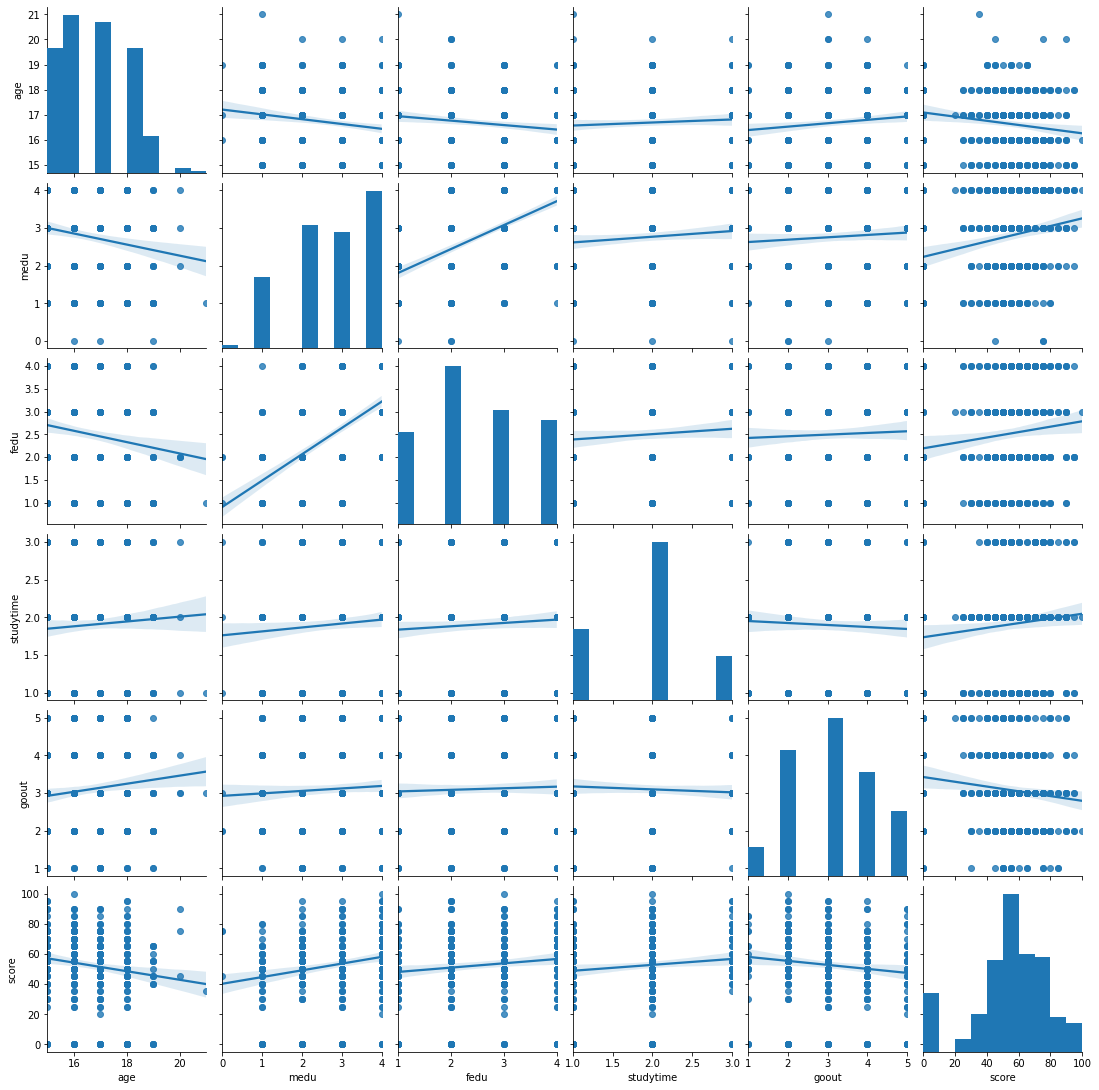

In [75]:
sns.pairplot(math, kind = 'reg')

1) Переменная age почему-то негативно коррелирует с оценками. Возможно это мало собранных данных и неравномерно собранных по возрастам. Возможно материал на этом тесте более свеж у 15 летних в головах, они могли недавно это проходить. Или вполне вероятно, что у подростков по старше больше других дел как работа. Также подростки в 18 и 19 лет в школе скорее всего это не самые лучшие ученики. Странно что все эти подростки брали один и тот же тест. Не удивлен что они проваливались раньше эти подростки постарше.

2) Переманная medu (образование матери) больше всего коррелирует с оценкой. Впринцепе логично обычно матери больше занимаются с детьми, но здесь уже подростки, вполне вероятно, что более образованные матери еще с детства могли своих детей увлечь математикой или как минимум помогать им с материалом.

3) Переменная fedu (образование отца) эта переменная меньше коррелирует с оценкой,
возможно отцы меньше времени уделяют детям, также надо учесть что среди отобранных отцов 
и матерей,  среди матерей выше количество высшего образования например.

4) Переменная studytime (время на учёбу помимо школы в неделю) положительно коррелирует
с оценкой. Эта переменная не удивлять, чем больше занимаешься после школы, тем лучше разбираешься
в материале. Эта переменная вполне могла даже больше коррелировать.

5) Переменная goout (проведение времени с друзьями) отрицательно коррелирует, что совсем не удивительно,
как и предыдущая переменная studytime вполне логично, чем больше ты гуляешь с друзьями тем меньше
у тебя остается время на занятия. 

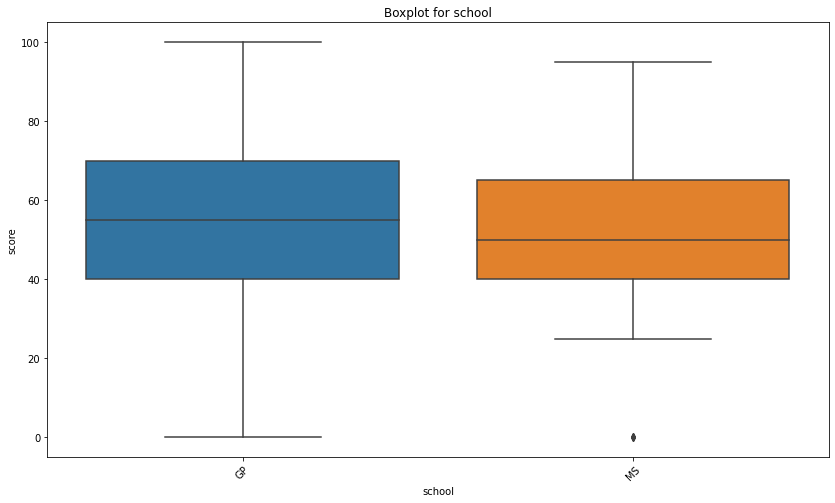

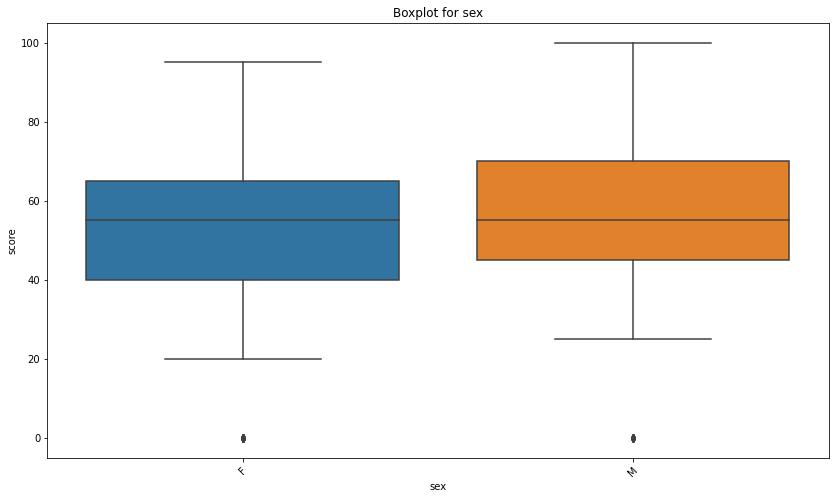

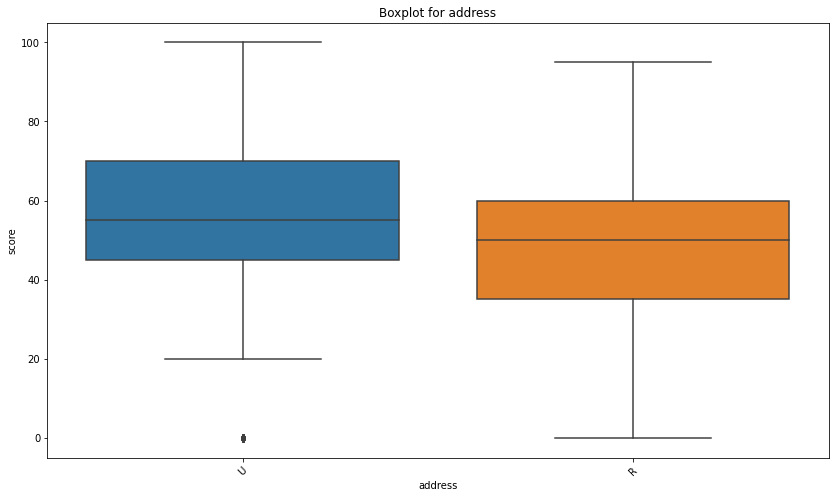

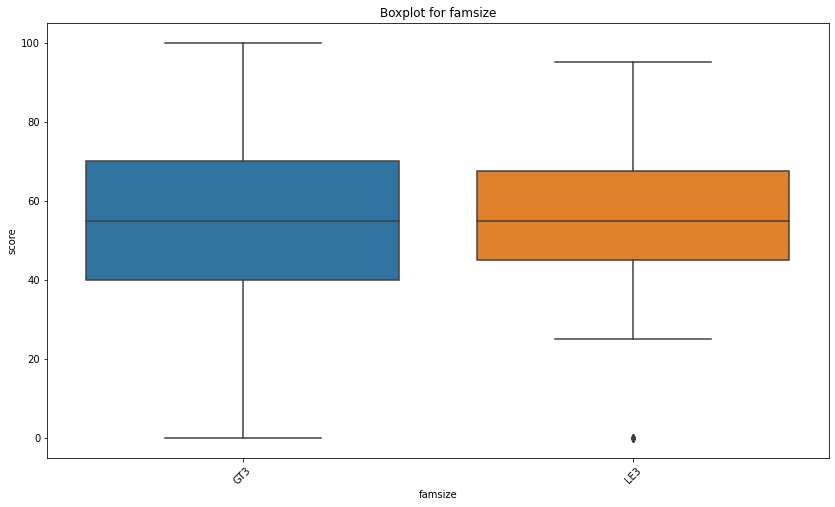

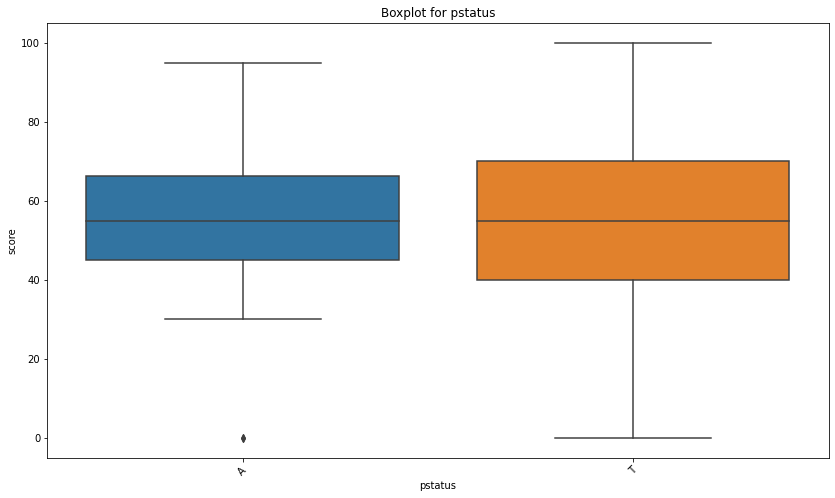

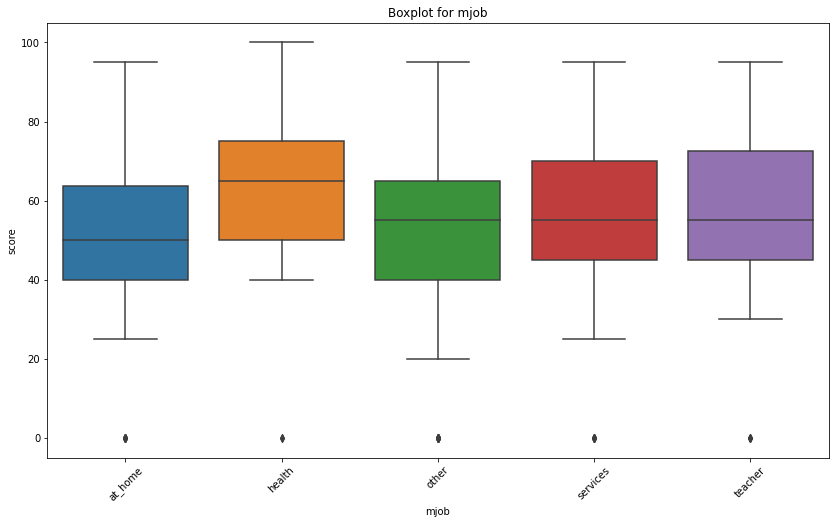

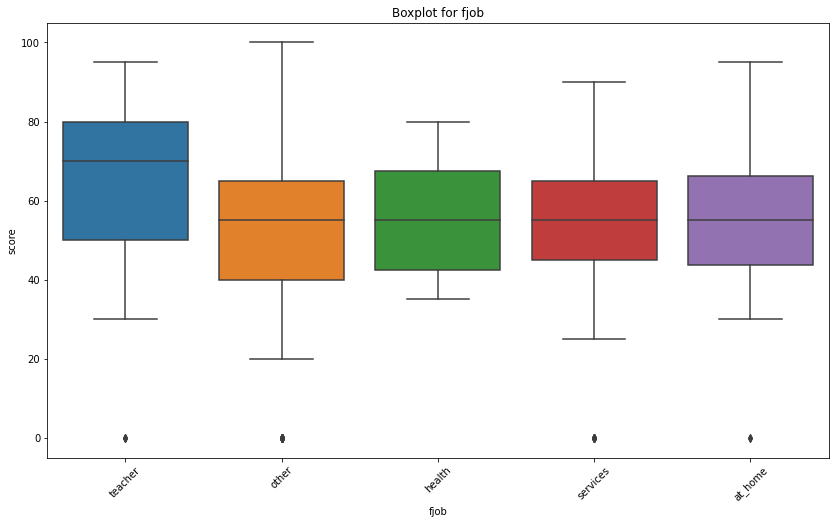

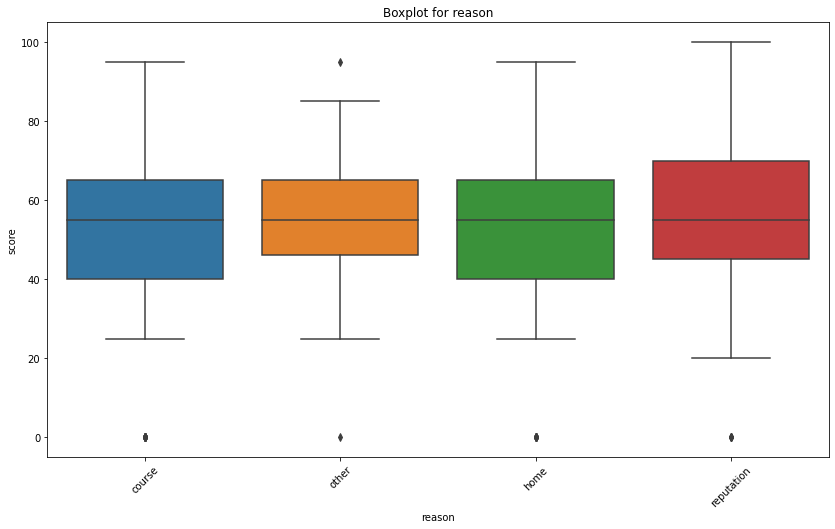

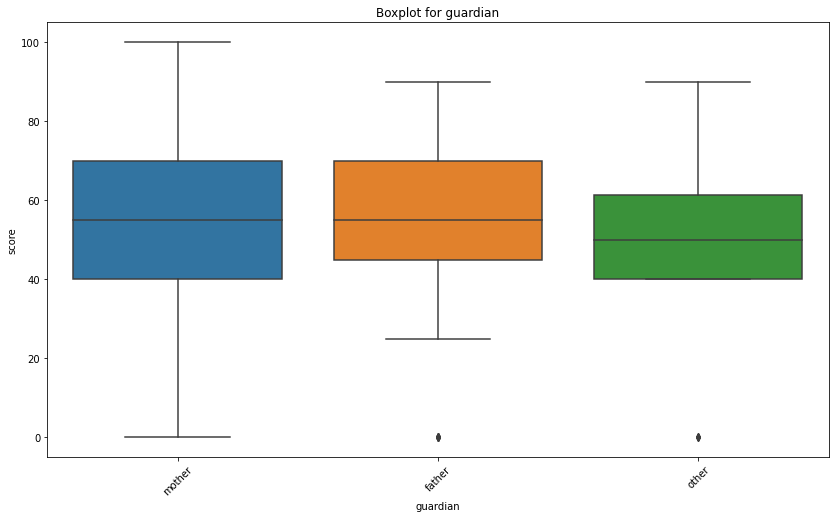

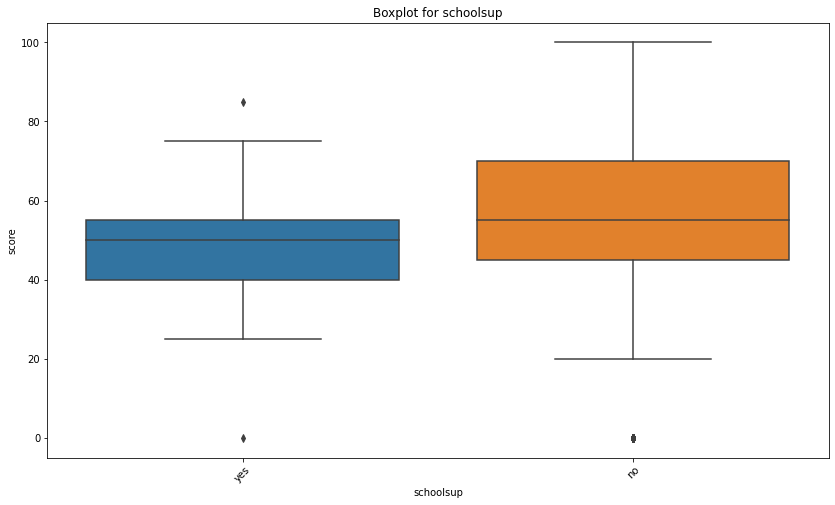

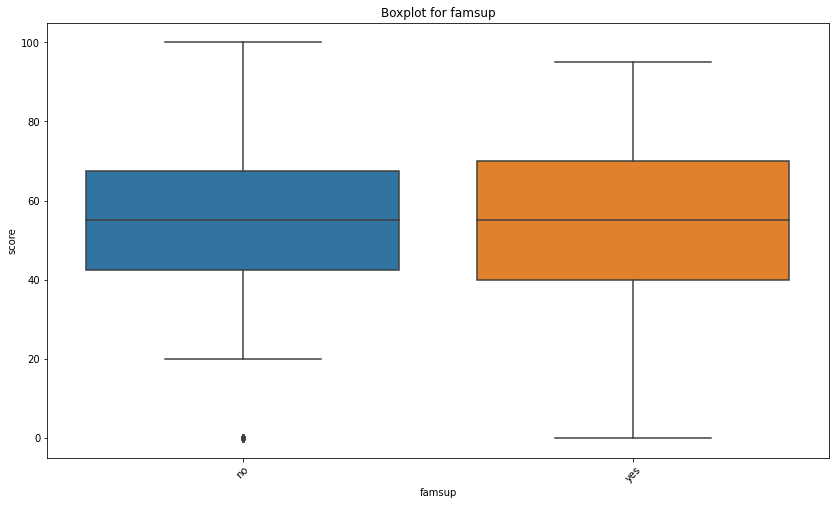

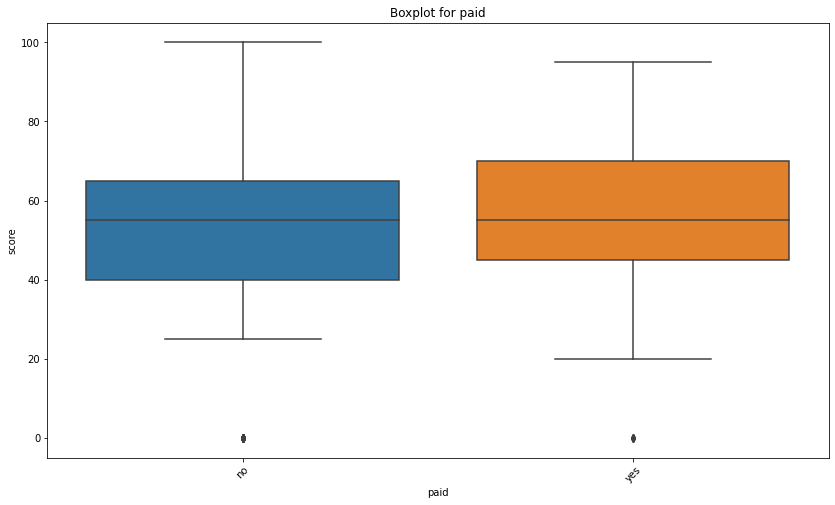

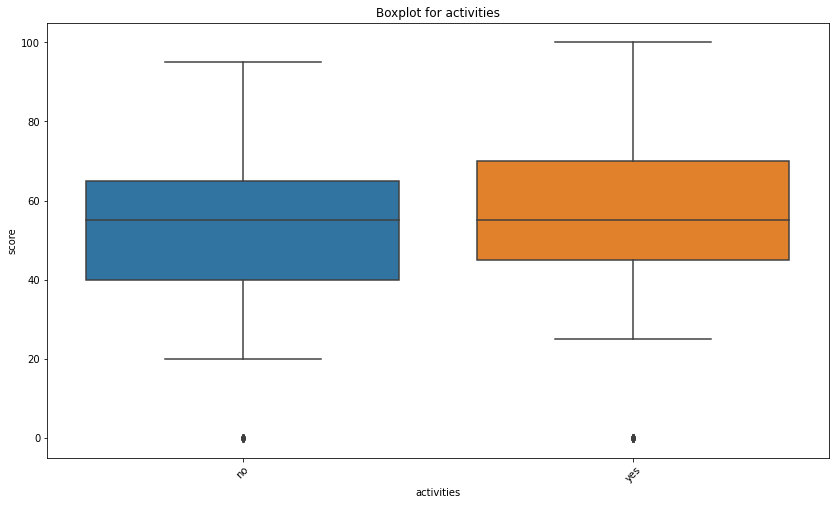

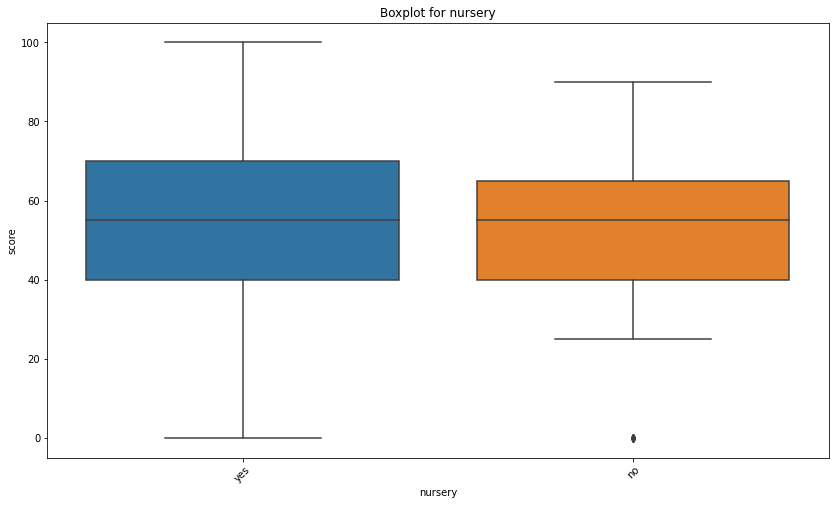

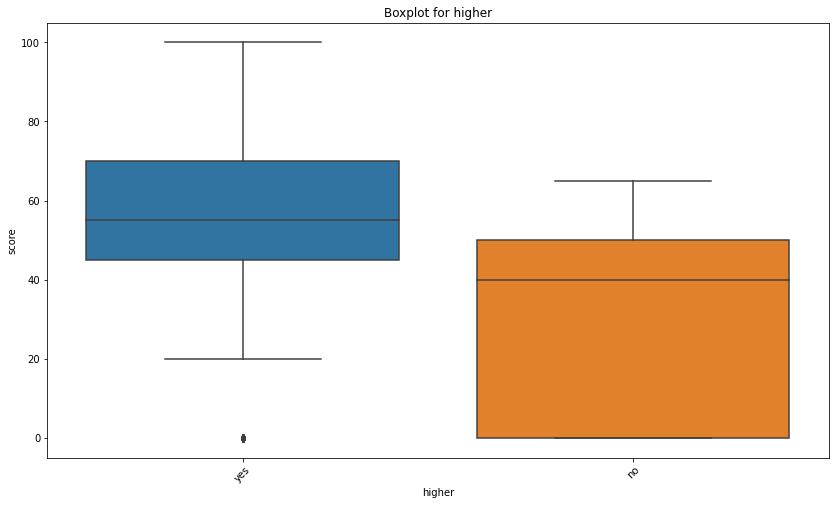

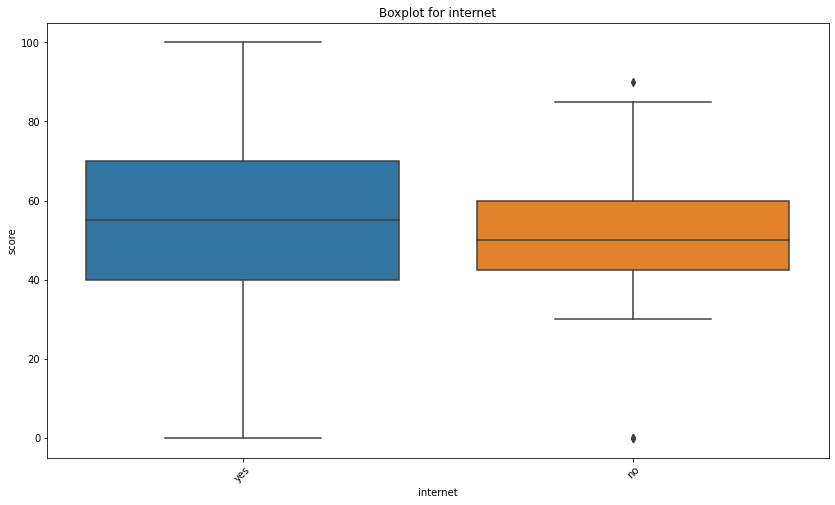

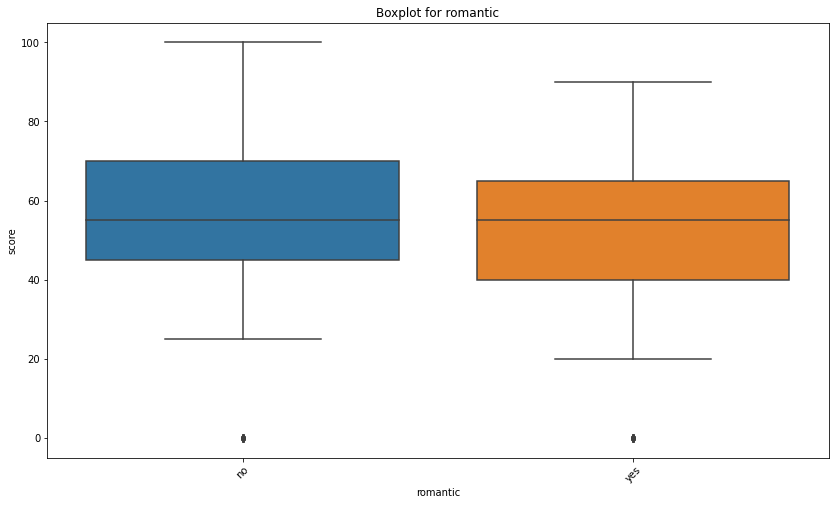

In [70]:
# Функция ниже состовляет boxplots для номинативных переменных.
# Горизонтальная ось это уникальные значения в конкретном номинотивном столбце
# Вертикальная ось это оценки на тесте.

def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.boxplot(x=column, y='score', data=math.loc[math.loc[:, column].isin(
        math.loc[:, column].value_counts().index)], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in math.columns:
    if math[col].dtypes == 'O':
        get_boxplot(col)

In [71]:
# Функция ниже использует тест Стьюдента чтобы статистическая разница в распределении оценок по номинативным признакам.


def get_stat_dif(column):
    cols = math.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'],
                     math.loc[math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


for col in math.columns:
    if math[col].dtypes == 'O':
        get_stat_dif(col)

Найдены статистически значимые различия для колонки mjob


C:\Users\Aleks\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Мне даже трудно представить почему именно из всех номинативных переменных только mjob работа матери имеет статистически значимые различия. Я бы предположил в первую очередь качество данных, на сколько они равномерно собирались. Но по-любому их очень мало для серьезного анализа. Но сюда по числовым переменным, где, образование матери больше всего коррелирует с оценкой тогда не удивительно, что и профессия матери играет значение. Матери играют большую роль в образование своих детей. Количество часов работы, напряжение на работе, будет играть роль захочет ли мать сесть и делать уроки с ребенком или нет.  

In [74]:
# Ниже новый датафрэйм для дальнейшего анализа использую ML. 
# В этой датафрэйме собраны все переменные, которые хоть заметно коррелируют с оценко
# по математике. 

math_predict = math[['age', 'medu', 'fedu', 'studytime', 'goout', 'mjob', 'score']]




    Честно говоря я бы не особо надеялся построить какую-то хорошую модель, на которую
    можно полагаться в дальнейшем. Данных мало собранно и не известно как они собирались. 
    На сколько равномерно, это был один тест по всем странам или тесты были разные в каждой стране.
    Также непонятно с возрастом, подростки разных возрастов в одном классе или они берут 
    разные гос экзамены как бы для 9, 10, 11 класса.
    Плюс проект задается целью "отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их 
    успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска."
    Если данные были собраны по разным странам, в статистике еще должна быть какая-то экономическая
    информация об этих странах.    